# Darya Ansaripour - 610300022
## Genetic

In [23]:
import random
from PIL import Image, ImageDraw
import numpy as np
import cv2
import copy
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [24]:
OFFSET = 10
PC = 0.9
PM = 0.01
TOP = 0.1


def generate_point(width, height):
    x = random.randrange(0 - OFFSET, width + OFFSET, 1)
    y = random.randrange(0 - OFFSET, height + OFFSET, 1)
    return (x, y)

class Triangle:
    def __init__(self, img_width, img_height):
        self.points = []
        for i in range(3):
            self.points.append(generate_point(img_width,img_height))

        self.color = (
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255),
        )

        self._img_width = img_width
        self._img_height = img_height

Notes on mutation and fitness:

There are some ways to calculate the fitness of a chromosome in terms of how much it is close to the original image, calculating MSE which is the mean of squared errors of the pixels is one of the ways that shows how much a chromosome is good! The closer MSE gets to zero the better our estimation of the original image gets! One can check the decrease of MSE through iterations using the plot below.

I chose both changing triangles' location and color as a mutation strategy to keep the diversity of population, note that i only apply mutation on bottom 90 percent of the population in order to reach convergence.

In [25]:
class Chromosome:  
    def __init__(self,img_height, img_width,target_image,num_triangles):
        self.img_height = img_height
        self.img_width = img_width  
        self.background_color = (0,0,0,255)
        self.triangles = [Triangle(img_width, img_height) for _ in range(num_triangles)]
        self.target_image = target_image
        self.num_triangles = num_triangles

    def mutate(self):
        #TODO: add mutate strategy
        for triangle_to_mutate in self.triangles:
        
            if random.random()<PM:
                mutation_type = random.choice(['color', 'position'])

                if mutation_type == 'color':
                    channel = random.choice([0, 1, 2, 3])  # choose R, G, B, or A channel to mutate
                    new_color = list(triangle_to_mutate.color)
                    new_color[channel] = min(255, max(0, new_color[channel] + random.randint(-30, 30)))
                    triangle_to_mutate.color = tuple(new_color)

                elif mutation_type == 'position':
                    point_index = random.randint(0, 2)  # choose one of the 3 vertices
                    new_point = generate_point(self.img_width, self.img_height)
                    triangle_to_mutate.points[point_index] = new_point
    
    def draw(self) -> Image:
        size = self.target_image.size
        img = Image.new('RGB', size, self.background_color)
        draw = Image.new('RGBA', size)
        pdraw = ImageDraw.Draw(draw)
        for triangle in self.triangles:
            colour = triangle.color
            points = triangle.points
            pdraw.polygon(points, fill=colour, outline=colour)
            img.paste(draw, mask=draw)
        return img
        

    def fitness(self) -> float:
        created_image = np.array(self.draw())/255
        #TODO: calculate fitness
        target_image = np.array(self.target_image)/255
        mse = np.mean((created_image - target_image) ** 2)
        return mse


In [26]:
class GeneticAlgorithm():
    def __init__(self,max_width,max_height,target_image, population_size, triangles_number):
        self.population_size = population_size
        self.max_width = max_width
        self.max_height = max_height
        self.population = [Chromosome(max_height,max_width,target_image, triangles_number) for i in range(population_size)]
        self.target_image = target_image
        self.total_rank = sum(range(1, self.population_size + 1))

    def calc_fitnesses(self):
        fitnesses = []
        for chromosome in self.population:  
            fitnesses.append(chromosome.fitness())
        return fitnesses
    
    def sort_population(self, fitnesses):
        return [x for _, x in sorted(zip(fitnesses, self.population), key=lambda pair: pair[0])]
    
    
    def cross_over(self, parent1: Chromosome, parent2: Chromosome):
        #TODO: apply cross over

        i = random.randint(0,parent1.num_triangles)
        child1 = Chromosome(self.max_height, self.max_width, self.target_image, parent1.num_triangles)
        child1.triangles = parent1.triangles[:i] + parent2.triangles[i:]
        child2 = Chromosome(self.max_height, self.max_width, self.target_image, parent1.num_triangles)
        child2.triangles = parent2.triangles[:i] + parent1.triangles[i:]

        return copy.deepcopy(child1) if child1.fitness()<child2.fitness() else copy.deepcopy(child2)

    def mutation(self):  
        #TODO: apply mutation
        for chromosome in self.population[int(TOP*self.population_size):]:
            chromosome.mutate()


    def run(self,n_generations):

        means = []
        for iteration in range(n_generations):
            fitnesses = self.calc_fitnesses()
            self.population = self.sort_population(fitnesses)[:]

            if iteration % 10 == 0:
                fit_arr = np.array(fitnesses)
                m = np.mean(fit_arr)
                clear_output()
                print(f"Fitness in Generation {iteration}: mean: {m}, max: {np.max(fit_arr)} min: {np.min(fit_arr)}")
                means.append((iteration,m))
                if iteration % 100 == 0:
                    #TODO: save the best photo from this generation to see the process

                    best_image = self.population[0].draw()
                    best_image.save(f"generation_{iteration}.png")
                    print(f"Saved best image of generation {iteration}.")

            # apply mutation and cross over and implement your method to select next generation chromosomes                
            new_population = self.population[:int(TOP*self.population_size)]

            while len(new_population) < self.population_size:
                parents = random.choices(self.population[:int(TOP*self.population_size)], k=2)
                child = self.cross_over(parents[0], parents[1])
                new_population.append(child)
            
            self.population = new_population[:]
            self.mutation()

        return(means)

    def get_best_of_population(self):
        fitnesses = self.calc_fitnesses()
        sorted_population = [x for _, x in sorted(zip(fitnesses, self.population), key=lambda pair: pair[0])]              
        best_population = sorted_population[0]
        image = best_population.draw()       
        cv2.imshow("Reconstructed Image", np.array(image))  
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [27]:
def resize(image,max_size):
    new_width = int((max_size/max(image.size[0],image.size[1]))* image.size[0])
    new_height = int((max_size/max(image.size[0],image.size[1]))* image.size[1])
    image = image.resize((new_width,new_height), resample=Image.Resampling.LANCZOS)  
    return image

Fitness in Generation 500: mean: 0.02125824954660018, max: 0.047334453337682866 min: 0.020080475652332626
Saved best image of generation 500.


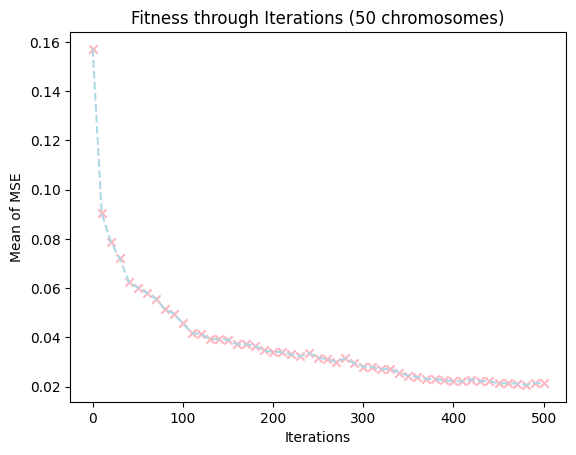

In [33]:
target_image_path = "./target_images/target_images/eagle.jpg"
image = Image.open(target_image_path)
# Use resize to resize your images
image = resize(image,50)

width,height = image.size
population_size = 50
triangles_number = 100
alg = GeneticAlgorithm(width,height,image, population_size, triangles_number)
means = alg.run(501)

x_values, y_values = zip(*means)
plt.scatter(x_values, y_values, color='lightpink', marker='x')
plt.plot(x_values, y_values, color='lightblue', linestyle='--')  # Optional: connect the points with lines
plt.xlabel("Iterations")
plt.ylabel("Mean of MSE")
plt.title("Fitness through Iterations (50 chromosomes)")
plt.show()

Fitness in Generation 500: mean: 0.01430017449388153, max: 0.02665657575369225 min: 0.013895532021483577
Saved best image of generation 500.


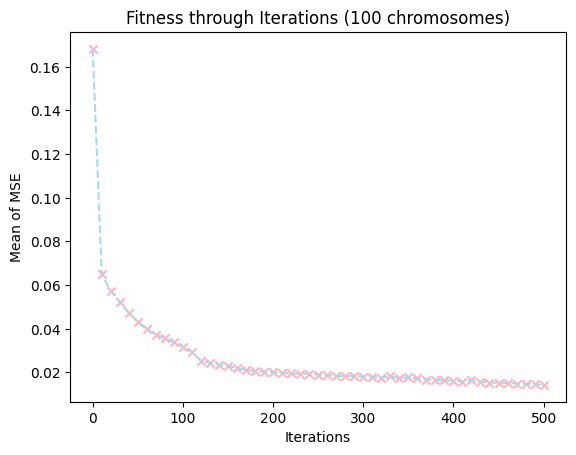

In [35]:
target_image_path = "./target_images/target_images/eagle.jpg"
image = Image.open(target_image_path)
# Use resize to resize your images
image = resize(image,50)

width,height = image.size
population_size = 100
triangles_number = 60
alg = GeneticAlgorithm(width,height,image, population_size, triangles_number)
means = alg.run(501)

x_values, y_values = zip(*means)
plt.scatter(x_values, y_values, color='lightpink', marker='x')
plt.plot(x_values, y_values, color='lightblue', linestyle='--')  # Optional: connect the points with lines
plt.xlabel("Iterations")
plt.ylabel("Mean of MSE")
plt.title("Fitness through Iterations (100 chromosomes)")
plt.show()

Fitness in Generation 500: mean: 0.012791427741466957, max: 0.03119299841941134 min: 0.012304983126148061
Saved best image of generation 500.


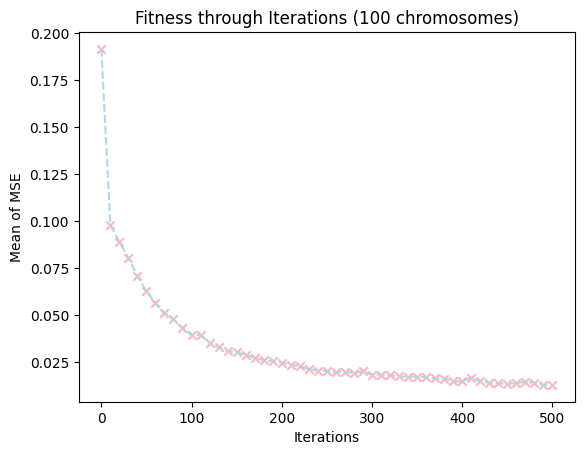

In [31]:
target_image_path = "./target_images/target_images/moon.jpg"
image = Image.open(target_image_path)
# Use resize to resize your images
image = resize(image,60)

width,height = image.size
population_size = 100
triangles_number = 50
alg = GeneticAlgorithm(width,height,image, population_size, triangles_number)
means = alg.run(501)

x_values, y_values = zip(*means)
plt.scatter(x_values, y_values, color='lightpink', marker='x')
plt.plot(x_values, y_values, color='lightblue', linestyle='--')  # Optional: connect the points with lines
plt.xlabel("Iterations")
plt.ylabel("Mean of MSE")
plt.title("Fitness through Iterations (100 chromosomes)")
plt.show()

## Question 1:
Each chromosome is a set of triangles, each triangle has 6 parameters for its location and 4 paramteres for its color.
we can assume that each parameter is an integer (o.w. there'd be infinitly many states.) by this assumption we conclude that each gene (triangle) has $w^6 \times 256^4$ possibilities and each chromosome has $(w^6 \times 256^4)^t$ where w is image width and t is number of triangles.

## Question 2:
1. Dynamically adjust the mutation rate depending on the diversity within the population. When diversity is low (i.e., many chromosomes are similar), increase the mutation rate to introduce more genetic variation. Conversely, when diversity is high, reduce the mutation rate to refine the solutions found.
2. In each generation, preserve a small percentage of the best-performing chromosomes (individuals) without subjecting them to mutation. This ensures that the best solutions found so far are retained and continue to influence future generations.

## Question 3:
1.  Roulette wheel selection assigns selection probabilities directly proportional to the fitness of each chromosome. Higher fitness (i.e., lower fitness score if minimizing which is the case here) results in a higher probability of selection, allowing the best chromosomes to have a higher chance of passing their genes to the next generation.
2. Rank-based selection assigns selection probabilities based on the rank of each chromosome rather than its absolute fitness score. Chromosomes are ranked from best to worst, and selection probabilities are distributed accordingly, with the top-ranked chromosomes receiving higher probabilities.



## Game

In [1]:
import numpy as np
import random
import pygame
import math
from time import sleep, time

ROW_COUNT = 6
COLUMN_COUNT = 7
SQUARESIZE = 100
RADIUS = int(SQUARESIZE / 2 - 5)
PLAYER = 1
CPU = -1
EMPTY = 0
PLAYER_PIECE = 1
CPU_PIECE = -1
BLUE = (0, 0, 255)
BLACK = (0, 0, 0)
RED = (255, 0, 0)
YELLOW = (255, 255, 0)
WINDOW_LENGTH = 4
WINING_SCORE = 10000000000000

pygame 2.6.1 (SDL 2.28.4, Python 3.12.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class Connect4UI:
    def __init__(self, width=COLUMN_COUNT*SQUARESIZE, height=(ROW_COUNT+1)*SQUARESIZE):
        pygame.init()
        self.width = width
        self.height = height
        self.size = (self.width, self.height)
        self.screen = pygame.display.set_mode(self.size)
        self.font = pygame.font.SysFont("monospace", 75)

    def draw_board(self, board):
        for c in range(COLUMN_COUNT):
            for r in range(ROW_COUNT):
                pygame.draw.rect(self.screen, BLUE, (c * SQUARESIZE, r * SQUARESIZE + SQUARESIZE, SQUARESIZE, SQUARESIZE))
                pygame.draw.circle(self.screen, BLACK, (int(c * SQUARESIZE + SQUARESIZE / 2), int(r * SQUARESIZE + SQUARESIZE + SQUARESIZE / 2)), RADIUS)

        for c in range(COLUMN_COUNT):
            for r in range(ROW_COUNT):
                if board[r][c] == PLAYER_PIECE:
                    pygame.draw.circle(self.screen, RED, (int(c * SQUARESIZE + SQUARESIZE / 2), self.height - int(r * SQUARESIZE + SQUARESIZE / 2)), RADIUS)
                elif board[r][c] == CPU_PIECE:
                    pygame.draw.circle(self.screen, YELLOW, (int(c * SQUARESIZE + SQUARESIZE / 2), self.height - int(r * SQUARESIZE + SQUARESIZE / 2)), RADIUS)

        pygame.display.update()
        sleep(0.2)
        

    def display_winner(self, winner):
        if winner == PLAYER:
            label = self.font.render("Player wins!!", 1, RED)
        elif winner == CPU:
            label = self.font.render("Computer wins!!", 1, YELLOW)
        else:
            label = self.font.render("It's a draw!!", 1, BLUE)
        self.screen.blit(label, (40, 10))
        pygame.display.update()
        sleep(5)

In [7]:
class Connect4Game:
    def __init__(self, ui, minimax_depth=1, prune=True):
        self.board = np.zeros((ROW_COUNT, COLUMN_COUNT))
        self.ui = Connect4UI() if ui else None
        self.minimax_depth = minimax_depth
        self.prune = prune
        self.current_turn = random.choice([1, -1])
        
    def drop_piece(self, board, row, col, piece):
        board[row][col] = piece

    def get_next_open_row(self, board,col):
        for r in range(ROW_COUNT):
            if board[r][col] == 0:
                return r

    def print_board(self, board):
        print(np.flip(board, 0))

    def winning_move(self, board, piece):
        for c in range(COLUMN_COUNT - 3):
            for r in range(ROW_COUNT):
                if all(board[r][c+i] == piece for i in range(WINDOW_LENGTH)):
                    return True

        for c in range(COLUMN_COUNT):
            for r in range(ROW_COUNT - 3):
                if all(board[r+i][c] == piece for i in range(WINDOW_LENGTH)):
                    return True

        for c in range(COLUMN_COUNT - 3):
            for r in range(ROW_COUNT - 3):
                if all(board[r+i][c+i] == piece for i in range(WINDOW_LENGTH)):
                    return True

        for c in range(COLUMN_COUNT - 3):
            for r in range(3, ROW_COUNT):
                if all(board[r-i][c+i] == piece for i in range(WINDOW_LENGTH)):
                    return True

        return False
    
    def evaluate_window(self, window, piece):
        score = 0
        opp_piece = PLAYER_PIECE
        if piece == PLAYER_PIECE:
            opp_piece = CPU_PIECE
        
        if window.count(piece) == 4:
            score += 100
        elif window.count(piece) == 3 and window.count(EMPTY) == 1:
            score += 5
        elif window.count(piece) == 2 and window.count(EMPTY) == 2:
            score += 2
        if window.count(opp_piece) == 3 and window.count(EMPTY) == 1:
            score -= 4
        
        return score
    
    def score_position(self, board, piece):
        score = 0  
        center_array = [int(i) for i in list(board[:, COLUMN_COUNT//2])]
        center_count = center_array.count(piece)
        score += center_count * 3
    
        for r in range(ROW_COUNT):
            row_array = [int(i) for i in list(board[r,:])]
            for c in range(COLUMN_COUNT-3):
                window = row_array[c:c+WINDOW_LENGTH]
                score += self.evaluate_window(window, piece)

        for c in range(COLUMN_COUNT):
            col_array = [int(i) for i in list(board[:,c])]
            for r in range(ROW_COUNT-3):
                window = col_array[r:r+WINDOW_LENGTH]
                score += self.evaluate_window(window, piece)

        for r in range(ROW_COUNT-3):
            for c in range(COLUMN_COUNT-3):
                window = [board[r+i][c+i] for i in range(WINDOW_LENGTH)]
                score += self.evaluate_window(window, piece)
                
        for r in range(ROW_COUNT-3):
            for c in range(COLUMN_COUNT-3):
                window = [board[r+3-i][c+i] for i in range(WINDOW_LENGTH)]
                score += self.evaluate_window(window, piece)
    
        return score
    
    def is_terminal_node(self, board):
        return self.winning_move(board, PLAYER_PIECE) or self.winning_move(board, CPU_PIECE) or len(self.get_valid_locations(board)) == 0
    
    def get_valid_locations(self, board):
        valid_locations = []
        for col in range(COLUMN_COUNT):
            if board[ROW_COUNT-1][col] == 0:
                valid_locations.append(col)
        return valid_locations
    
    def best_cpu_score(self, board, moves):
        move = None
        max_score = -math.inf
        for col in moves:
            row = self.get_next_open_row(board, col)
            b_copy = board.copy()
            self.drop_piece(b_copy, row, col, CPU_PIECE)
            score = self.heuristic(b_copy, CPU_PIECE)
            if score > max_score:
                max_score = score
                move = col
        return move
    
    def heuristic(self, board, piece):
        if(self.is_terminal_node(board)):
            if self.winning_move(board, piece):
                return WINING_SCORE
            elif self.winning_move(board, -piece):
                return -WINING_SCORE
            else:
                return 0
        else:
            return self.score_position(board, piece) - self.score_position(board, -piece)
        
    #TODO: Implement minimax algorithm with alpha-beta pruning and depth limiting
    #self.prune is a boolean that indicates whether to use alpha-beta pruning or not
    #Use the heuristic function as the evaluation function for non terminal nodes
    #Return the column and the score of the best move
    def minimax(self, board, depth, alpha, beta, player):
        valid_locations = self.get_valid_locations(board)
        is_terminal = self.is_terminal_node(board)
        
        # Check terminal states
        if depth == 0 or is_terminal:
                return None, self.heuristic(board, PLAYER_PIECE)
        
        # Maximizing player
        if player == PLAYER_PIECE:
            value = -math.inf
            column = 0
            for col in valid_locations:
                row = self.get_next_open_row(board, col)
                b_copy = board.copy()
                self.drop_piece(b_copy, row, col, PLAYER_PIECE)
                new_score = self.minimax(b_copy, depth - 1, alpha, beta, CPU_PIECE)[1]
                if new_score > value:
                    value = new_score
                    column = col
                if self.prune and value >= beta:
                    break
                alpha = max(alpha, value)
            return column, value

        # Minimizing player
        else:
            value = math.inf
            column = 0
            for col in valid_locations:
                row = self.get_next_open_row(board, col)
                b_copy = board.copy()
                self.drop_piece(b_copy, row, col, CPU_PIECE)
                new_score = self.minimax(b_copy, depth - 1, alpha, beta, PLAYER_PIECE)[1]
                if new_score < value:
                    value = new_score
                    column = col
                if self.prune and alpha >= value:
                    break
                beta = min(beta, value)
            return column, value
        
        
    def get_cpu_move(self, board, randomness_percent=30):
        moves = self.get_valid_locations(board)
        if len(moves) == 0:
            return None
        random_move = random.choice(moves)
        score_move = self.best_cpu_score(board, moves)
        move = random.choice([score_move] * (100 - randomness_percent) + [random_move] * randomness_percent)
        return move, self.get_next_open_row(board, move)


    def get_human_move(self, board, depth = 1):
        col = self.minimax(board, depth, -math.inf, math.inf, self.current_turn)[0]
        return col, self.get_next_open_row(board, col)

    def play(self):
        winner = None
        while not self.is_terminal_node(self.board):
            if self.ui:
                self.ui.draw_board(self.board)
            if self.current_turn == PLAYER:
                col, row = self.get_human_move(self.board, self.minimax_depth)
                if col is not None:
                    self.drop_piece(self.board, row, col, PLAYER_PIECE)
                    if self.winning_move(self.board, PLAYER_PIECE):
                        winner = PLAYER
                    self.current_turn = CPU
            else:
                col, row = self.get_cpu_move(self.board)
                if col is not None:
                    self.drop_piece(self.board, row, col, CPU_PIECE)
                    if self.winning_move(self.board, CPU_PIECE):
                        winner = CPU
                    self.current_turn = PLAYER
            
            if self.ui:
                self.ui.draw_board(self.board)
                if winner is not None:
                    self.ui.display_winner(winner)
                            
        if winner is None:
            winner = 0
        return winner

Complete the Connect4Game class below by implementing the `minimax algorithm` with `alpha-beta pruning` and `depth limiting`. Don't change other parts of the code unless you want to define a new heuristic function.

In [8]:
def print_results(results, depth, pruning, start, end):
    pruning_status = "Enabled" if pruning else "Disabled"
    print(
        f'Depth: {depth} | Pruning: {pruning_status} -> User Wins: {results[1]:3}, CPU Wins: {results[-1]:2}, Ties: {results[0]:2}, Time: {end - start:.2f}s'
    )

Use the code below to test the game with the UI. Pygame is not compatible with Jupyter Notebook and will not work in this environment. To use Pygame, please run the code in a separate `.py` file.

In [9]:
# game = Connect4Game(True, 3, True)
# game.play()

Run the following code to test the results of the game and the time taken to play the game in different `depths` and with `pruning` enabled and disabled.

In [10]:
def check_results():
    for pruning in [True, False]:  
        for d in range(1, 4):
            results = {-1: 0, 0: 0, 1: 0}
            start = time()
            for _ in range(20):  
                game = Connect4Game(False, d, pruning)  
                results[game.play()] += 1
            end = time()
            print_results(results, d, pruning, start, end)

check_results()

Depth: 1 | Pruning: Enabled -> User Wins:  12, CPU Wins:  8, Ties:  0, Time: 0.73s
Depth: 2 | Pruning: Enabled -> User Wins:  20, CPU Wins:  0, Ties:  0, Time: 2.55s
Depth: 3 | Pruning: Enabled -> User Wins:  20, CPU Wins:  0, Ties:  0, Time: 7.36s
Depth: 1 | Pruning: Disabled -> User Wins:  13, CPU Wins:  7, Ties:  0, Time: 0.56s
Depth: 2 | Pruning: Disabled -> User Wins:  19, CPU Wins:  1, Ties:  0, Time: 3.92s
Depth: 3 | Pruning: Disabled -> User Wins:  20, CPU Wins:  0, Ties:  0, Time: 18.60s


## Question 1:
Deeper Search: The deeper the minimax algorithm searches, the more game states it evaluates and the more future moves it considers. This generally leads to a better move selection and increases the chances of winning.

Exponential Growth: Each additional level of depth increases the number of possible game states the algorithm must evaluate exponentially. This is because each move typically generates multiple possible moves for the next level (for example, 7 possible moves in Connect4 if all columns are available).

Alpha-Beta Pruning Efficiency: While alpha-beta pruning reduces the number of nodes that need to be evaluated, its effectiveness diminishes as the search depth grows, especially if the branching factor is high.

Pruning Impact: With alpha-beta pruning, the number of nodes visited at deeper depths is less than without pruning. Pruning saves time by not exploring branches that won’t affect the outcome (note that since the opponent acts randomly we can not guarantee this fact!), but it doesn’t eliminate exponential growth entirely.

## Question 2:
By sorting children ascending in max levels and descending in min levels we can prune all other nodes when we visit the first smaller/bigger node than the value we've found so far.

## Question 3:

The branching factor in a game search algorithm like minimax refers to the average number of possible moves (or child nodes) that can be generated from any given state. In Connect4, the branching factor is based on the number of columns (usually 7), meaning that in the early stages of the game, the branching factor can be as high as 7, because all columns may be available for moves.

However, the branching factor changes as the game progresses because some columns start to fill up. Once a column is completely filled, it’s no longer a valid move.

## Question 4:
It does this by "pruning" branches of the search tree that cannot influence the final decision, thus saving computational resources while preserving the accuracy of the result.

In the minimax algorithm, alpha represents the best score that the maximizer can guarantee up to a certain point, and beta represents the best score that the minimizer can guarantee. When evaluating nodes, if the minimizer finds a move that’s worse for the maximizer than what’s already been found (meaning it’s less than alpha), or vice versa, further exploration of that branch is unnecessary.

## Question 5: 
Minimax is not optimal when the opponent has randomness because it assumes that the opponent always makes the best possible move to minimize our score. However, when randomness is involved, the opponent’s moves can vary unpredictably, which introduces an element of chance that minimax doesn’t account for. Instead of deterministic moves, the game outcome now depends on the probability of various moves, and expectimax is a better approach for handling this probabilistic aspect.